# Forecasting the Price of Refined sugar in the Philippines using ARIMAX model

## What is Arimax model?

ARIMAX is an extension of ARIMA model with the inclusion of the Exogeneous variables. Those exogeneous variable make the forecasting more accurate as oppose to the traditional ARIMA model.

### Components of ARIMA model
**AR** - The AutoRegressive component checks the previous data on how it affects the current data.

**MA** - The Moving Average component checks the errors of the previous data and how it affects the current data.

**I** - The Integrated is responsible for differencing the data to achieve stationarity.

#### What is Differencing?
Differencing is the Process of taking the difference of the current and previous data.
example jan = 10, feb = 12, mar = 9, apr = 11.
difference(feb) = jan - feb 

Since there is no previous value in January, it will be empty


#### What is Stationarity?
Stationarity is when the mean and variance of the time series is constant. One way to check for stationarity is through the Augmented Dickey-Fuller test. The ADF test check the existence of unit root, if it exist the time series is not stationary. Additionally, the p-value must be less than 0.05 in order to reject the existence of unit root.



The objective is to forecast the Price of refined sugar in the Phillippines, subject to the following exogeneous variables
- Production of refined sugar
- withdrawals of refined sugar
- global price of refined sugar
- exchange rate of USD to PHP
- temperature in Negros Occidental
- total precipitation in Negros Occidental

Why Negros Occidental?

Most of the sugarcane are produce in Negros Region :) 

## Load the Data set

In [24]:
from utils import *
from richutils import *
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))
df


,Index,Price,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,TempAvg,Precipitation,Inflation
Month,,,,,,,,,,
2014-09-01,1,51.51,537770.0,1418420,0.1470,44.08,28,27,456.59,3.9
2014-10-01,2,51.46,1623075.0,1355836,0.1648,44.80,29,27,436.73,3.7
2014-11-01,3,51.28,2277043.0,2156729,0.1588,44.95,29,28,265.32,3.0
2014-12-01,4,51.65,2223994.0,1663150,0.1499,44.69,28,27,182.00,1.9
2015-01-01,5,51.19,2259613.0,1714490,0.1506,44.60,28,27,82.83,1.5
...,...,...,...,...,...,...,...,...,...,...
2024-04-01,116,85.85,1476667.0,1042072,0.2069,56.95,33,29,22.90,3.8
2024-05-01,117,85.54,590428.0,1177536,0.1880,57.76,32,29,130.78,3.9
2024-06-01,118,86.73,470766.0,1183388,0.1916,58.70,30,28,330.53,3.7


The datapoint are from September 2014 up to August 2024

In [25]:
price = df['Price']
production = df['Production']
withdrawals = df['Withdrawals']
globalPrice = df['GlobalPrice']
exchangeRate = df['ExchangeRate']
temperature = df['TempMax']
precipitation = df['Precipitation']

# Pre-ARIMAX

<Axes: xlabel='Month'>

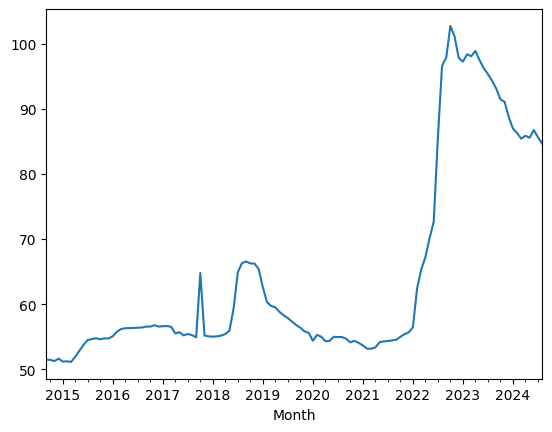

In [26]:
price.plot()

P-value: 5.67356265349366e-06 < 0.05
The time series is stationary


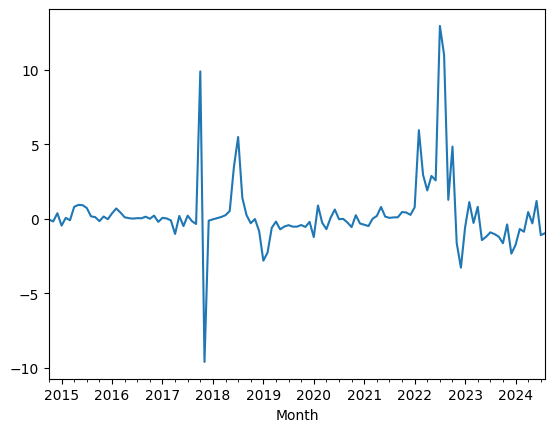

In [27]:
Differencing(price, 1)

In [28]:
price_train, price_test = train_test_split(price, 24)

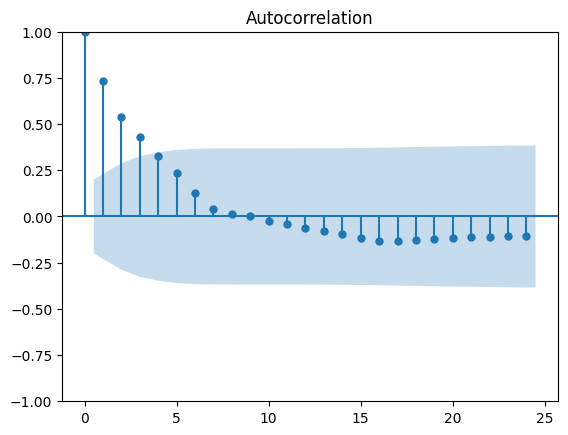

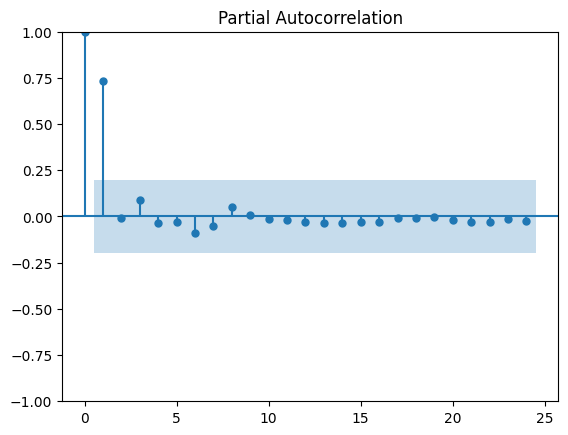

In [29]:
ACF_PACF(price_train, lags=24)

In [30]:
p = [0,1] # AR
d = [1]   # I
q = [0,1,2,3] # MA

a,b,c,d = Eval_possible_models(price_train, price_test, p,d,q)
a

,Model,Order,MSE,RMSE,MAE,MAPE,AIC,BIC
0,ARIMA,"(0, 1, 0)",47.165733,6.867731,5.488333,6.180969,448.669839,451.223716
1,ARIMA,"(0, 1, 1)",64.864335,8.053840,6.288555,7.125132,444.684156,449.791910
2,ARIMA,"(0, 1, 2)",145.338765,12.055653,10.573663,11.827591,442.518661,450.180292
3,ARIMA,"(0, 1, 3)",203.995696,14.282706,12.976780,14.436747,443.184824,453.400331
4,ARIMA,"(1, 1, 0)",115.353579,10.740278,9.130338,10.256450,442.101393,447.209147
5,ARIMA,"(1, 1, 1)",6071.974805,77.922877,68.643196,76.644387,434.260272,441.921902
6,ARIMA,"(1, 1, 2)",7562.219883,86.961025,76.915176,85.823385,435.457356,445.672864
7,ARIMA,"(1, 1, 3)",7714.234864,87.830717,77.909064,86.887233,437.200272,449.969657


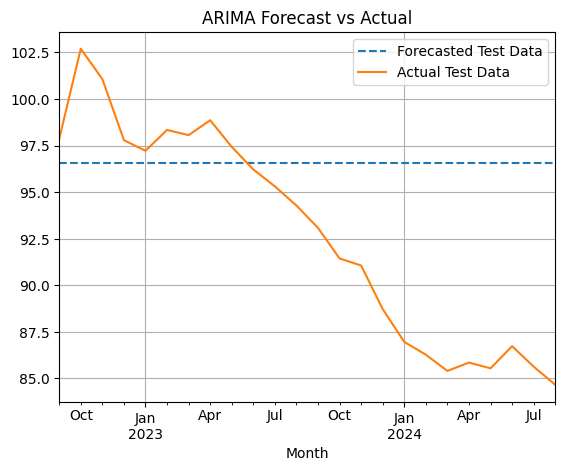

Evaluation of ARIMA(0, 1, 0)
MSE: 47.1657
MAE: 5.4883
RMSE: 6.8677
MAPE: 6.18%
AIC: 448.67
BIC: 451.22


In [31]:
model,pred = Model(price_train, price_test, (0,1,0))
Evaluate(price_train, price_test, (0,1,0))

# I. Forecasting of Exogeneous Variables

The forecasting of exogeneous variable is done using ARIMA 

Note: Some of the evaluation metric for exogeneous variable is bit higher

In [32]:
forecast_df = pd.read_csv('exogdata.csv')
forecast_df.set_index('Month', inplace=True)

x1 = forecast_df['Production']
x2 = forecast_df['Withdrawals']
x3 = forecast_df['GlobalPrice']
x4 = forecast_df['ExchangeRate']
x5 = forecast_df['TempMax']
x6 = forecast_df['Precipitation']

future_exog = pd.concat([x1, x2, x3, x4], axis=1)


In [33]:
future_exog.head()

,Production,Withdrawals,GlobalPrice,ExchangeRate
Month,,,,
2024-09-01,7.125252e+05,7.023642e+05,0.180266,56.841096
2024-10-01,1.160439e+06,1.017522e+06,0.178647,56.917426
2024-11-01,1.469658e+06,9.729463e+05,0.178695,56.774533
2024-12-01,1.964885e+06,1.036543e+06,0.179967,56.819952
2025-01-01,2.169354e+06,1.225489e+06,0.180846,56.846766


The Forecasted value for the exegeneous variables are from September 2024 to August 2027

# II. ARIMAX model

The main variable we want to forecast is the Price, thus the price is the dependent variable. 

In [34]:
# Set up the Variables

y = price 
exog = pd.concat([production, withdrawals, globalPrice, exchangeRate], axis=1)

In [35]:
ADF_test(y)

P-value: 0.663961545174224 < 0.05
The time series is not stationary


P-value: 5.67356265349366e-06 < 0.05
The time series is stationary


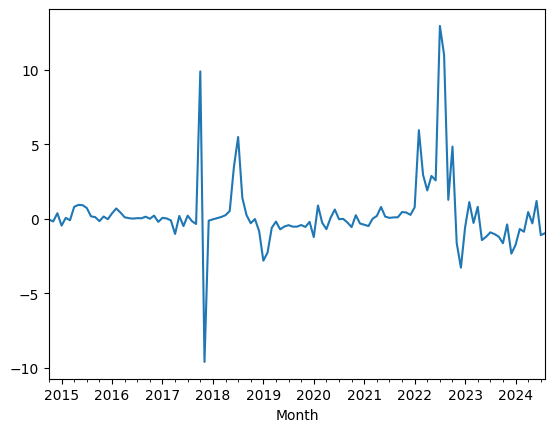

In [36]:
Differencing(y, 1)

the **I** component is 1

### Train test split

The total number of data points is 120. 80% of the data will be used for training and the remaining 20% is for testing. 20% of 120 = 24 

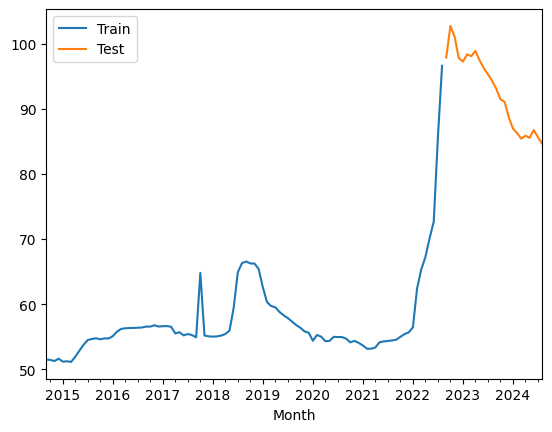

In [37]:
split = 24 
y_train, y_test = train_test_split(y, split)
exog_train, exog_test = train_test_split(exog, split)

y_train.plot()
y_test.plot()
plt.legend(['Train', 'Test'])

<Axes: xlabel='Month'>

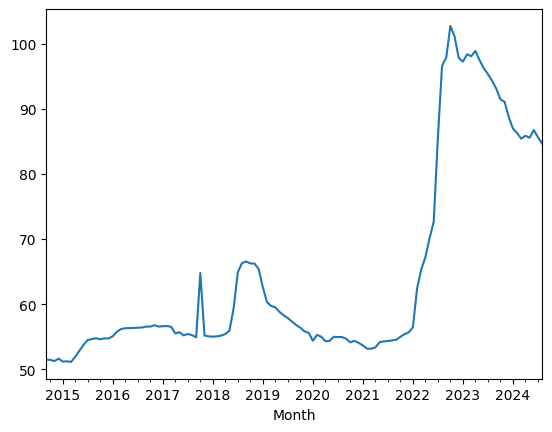

In [38]:
price.plot()

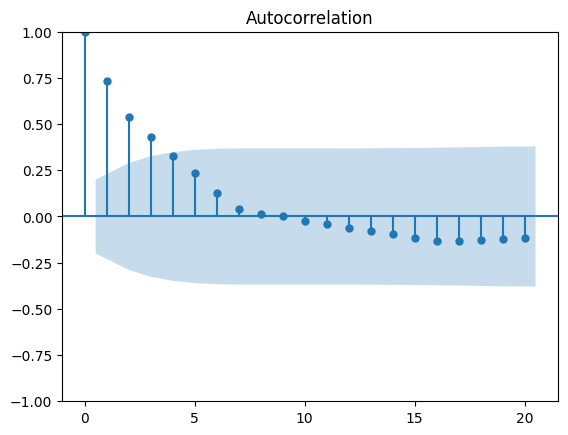

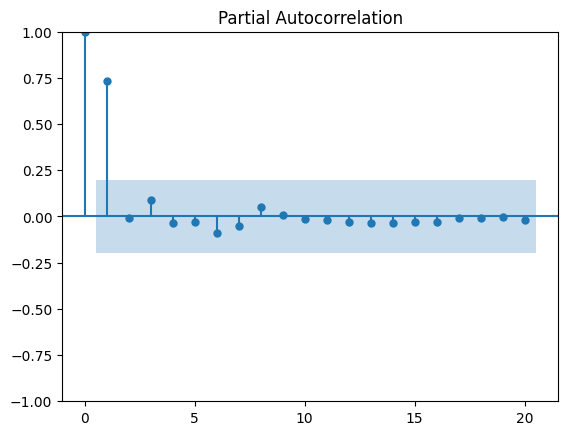

In [39]:
ACF_PACF(y_train, lags=20)

### ACF and PACF

The ACF helps to identify the **MA** or **q** component.

The PACF helps to identify the **AR** or **p** component.

In [40]:
# Evaluate other parameters
p = [0,1]
d = [1]
q = [0,1, 2, 3]

all, mape,aic, bic = Eval_possible_models(y_train, y_test, p, d, q, exog_train, exog_test)
all

,Model,Order,MSE,RMSE,MAE,MAPE,AIC,BIC
0,ARIMAX,"(0, 1, 0)",61.485390,7.841262,6.117842,6.913829,780.160897,792.930281
1,ARIMAX,"(0, 1, 1)",69.080728,8.311482,6.334531,7.188390,442.835041,458.158302
2,ARIMAX,"(0, 1, 2)",64.915996,8.057046,6.208445,7.031323,445.431200,463.308338
3,ARIMAX,"(0, 1, 3)",121.741740,11.033664,8.718960,9.870956,445.757166,466.188181
4,ARIMAX,"(1, 1, 0)",77.100244,8.780674,6.573789,7.482521,442.531789,457.855050
5,ARIMAX,"(1, 1, 1)",61.485390,7.841262,6.117842,6.913829,445.562389,463.439527
6,ARIMAX,"(1, 1, 2)",61.485390,7.841262,6.117842,6.913829,447.544454,467.975469
7,ARIMAX,"(1, 1, 3)",1359.939795,36.877362,33.562623,37.271670,442.321968,465.306860


Based on the different ARIMAX model in the table.

ARIMAX (1,1,2) has the lowest AIC

ARIMAX (1,1,0) has the lowest BIC

But among those the model with the lowest MAPE and relatively low AIC and BIC is the ARIMAX (1,1,1)

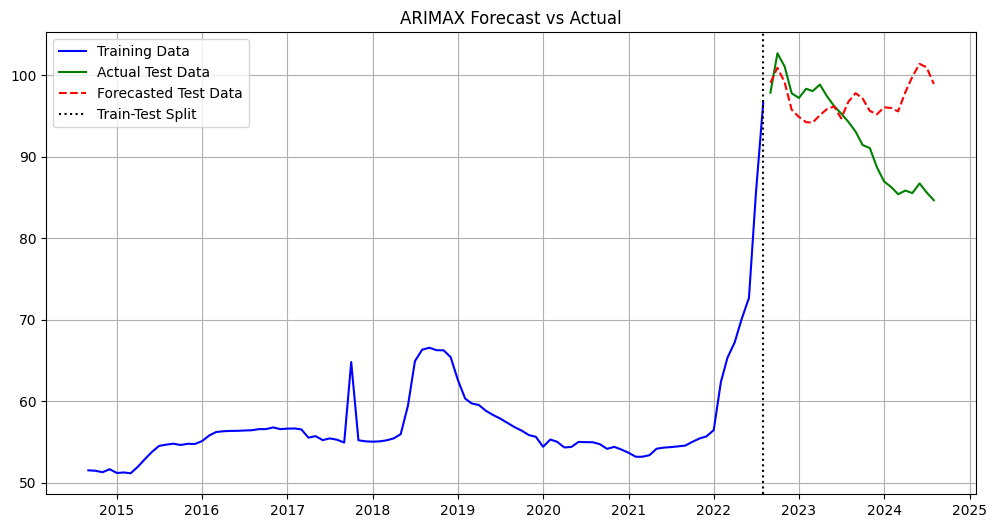

In [41]:
order = (1,1,1)
model, pred = Model(y_train,y_test, order, exog_train, exog_test) 

In [42]:
test_results = pd.DataFrame({'Test': y_test, 'Pred': pred})
test_results.head()

,Test,Pred
2022-09-01,97.86,99.078517
2022-10-01,102.70,100.926487
2022-11-01,101.07,99.133996
2022-12-01,97.79,95.768808
2023-01-01,97.22,94.887182


,lb_stat,lb_pvalue
1,0.389633,0.532492


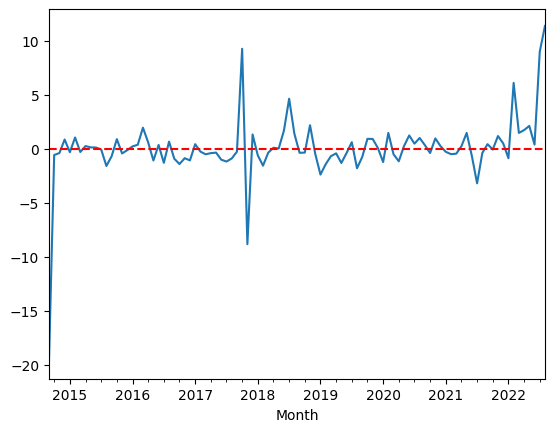

In [43]:
resid = Residuals(model)
LjungBox(resid, lags=1) # 0.05

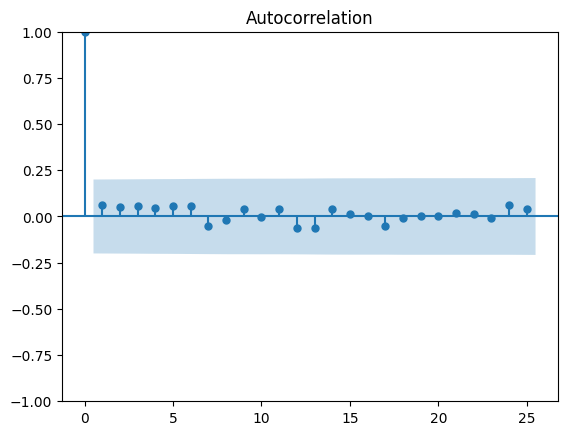

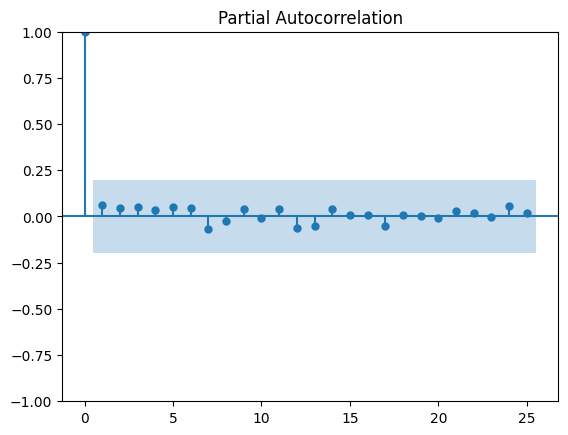

In [44]:
ACF_PACF(resid,25)

In [45]:
# Evaluate the model

Evaluate(y_train, y_test, order, exog_train, exog_test)

Evaluation of ARIMAX(1, 1, 1)
MSE: 61.4854
MAE: 6.1178
RMSE: 7.8413
MAPE: 6.91%
AIC: 445.56
BIC: 463.44


My Evaluation:

7% MAPE is OK

MAPE < 10% is good


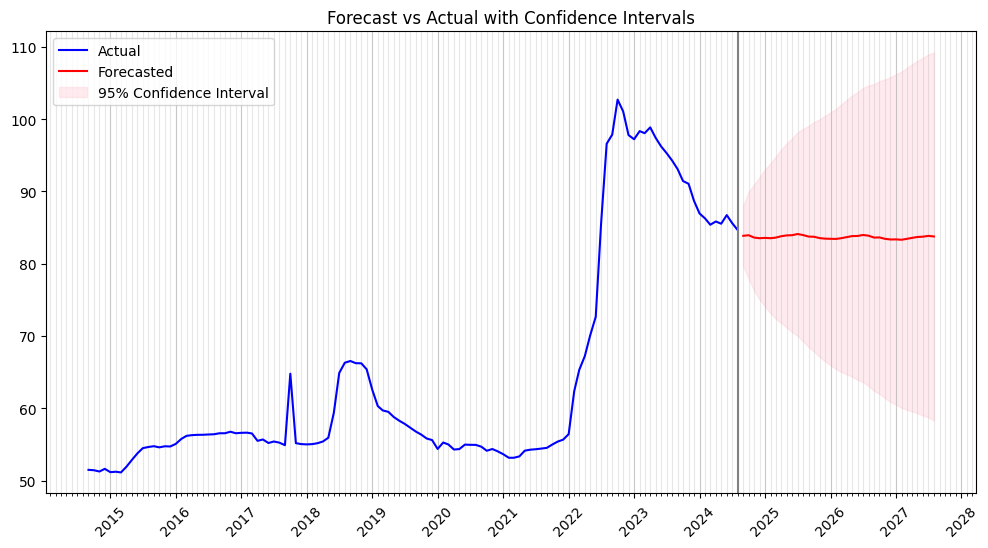

In [46]:
forecast, model = Forecast(y, order, 36, exog, future_exog)
confidence = model.get_forecast(steps=36, exog=future_exog).conf_int()

Forecasted_plot(y, forecast, confidence.values)

In [47]:
forecast_df = pd.DataFrame(forecast, columns=['Forecast'])
forecast_df.head(12)

,Forecast
2024-09-01,83.867734
2024-10-01,83.948319
2024-11-01,83.622782
2024-12-01,83.535609
2025-01-01,83.580750
2025-02-01,83.537487
2025-03-01,83.615431
2025-04-01,83.810171
2025-05-01,83.922682
2025-06-01,83.953796


In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -262.761
Date:                Tue, 29 Apr 2025   AIC                            539.523
Time:                        20:40:33   BIC                            558.976
Sample:                    09-01-2014   HQIC                           547.422
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Production    -3.57e-07   5.96e-07     -0.599      0.549   -1.52e-06     8.1e-07
Withdrawals   4.308e-07   7.37e-07      0.584      0.559   -1.01e-06    1.88e-06
GlobalPrice     -0.0349      0.001    -40.219      0.000      -0.037      -0.033
ExchangeRate     1.3712      0.232      5.921      0.000       0.917       1.825
ar.L1                 0      0.031          0      1.000      -0.060       0.060
ma.L1                -0      0.031         -0      1.000      -0.060       0.060
sigma2           4.6810      0.274     17.062      0.000       4.143       5.219
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):               755.52
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             2.03
Prob(H) (two-sided):                  0.06   Kurtosis:                        14.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+19. Standard errors may be unstable.
"""

In [49]:
latest_actual_price = [84, 83.15,83.13, 82.83, 83.65, 83.07, 83.14, 83.49] # retrieved from department of Agriculture price monitoring
forecasted_price = forecast.head(8).values.tolist()


from sklearn.metrics import mean_absolute_percentage_error as mape
mape_value = mape(latest_actual_price, forecasted_price) * 100
print(f'MAPE: {mape_value:.2f}%')


MAPE: 0.52%


**Update**

I remove the temperature in the exogenous variable, it went from 0.61 to 0.42 percent

The forecasted price vs the latest actual price shows a Mean absolute percentage error of 0.42%. That's fucking good